In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# import dataset
ds = pd.read_csv("homework/radar_parameters.csv")
ds

,Unnamed: 0,Zh (dBZ),Zdr (dB),Ldr (dB),Kdp (deg km-1),Ah (dBZ/km),Adr (dB/km),R (mm/hr)
0,0,23.144878,0.418637,-41.757733,0.005395,0.000290,0.000012,2.393520
1,1,22.737156,0.322850,-43.772069,0.005194,0.000360,0.000012,3.502699
2,2,26.869826,0.330948,-43.577399,0.013385,0.000903,0.000030,8.627561
3,3,28.540561,0.399480,-42.139731,0.018872,0.001036,0.000043,8.424447
4,4,30.500127,0.543758,-39.763087,0.027438,0.001157,0.000064,8.189291
...,...,...,...,...,...,...,...,...
18964,18964,31.515997,0.579955,-39.244229,0.034048,0.001417,0.000080,10.648020
18965,18965,29.993334,0.567935,-39.399188,0.024134,0.001032,0.000057,7.981875
18966,18966,31.685913,0.655681,-38.375696,0.033971,0.001165,0.000081,6.822691
18967,18967,32.980096,0.768586,-37.166218,0.043117,0.001285,0.000105,6.801169


In [3]:
# We need to establish the features matrix and target array
X_dsfeatures = ds.drop('R (mm/hr)', axis=1)
X_dsfeatures.shape

(18969, 7)

In [4]:
y_dstarget = ds['R (mm/hr)']
y_dstarget.shape

(18969,)

1. Split the data into a 70-30 split for training and testing data.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_dsfeatures, y_dstarget, random_state=0,
                                  train_size=0.7)

2. Using the split created in (1), train a multiple linear regression dataset using the training dataset, and validate it using the testing dataset.  Compare the $R^2$ and root mean square errors of model on the training and testing sets to a baseline prediction of rain rate using the formula $Z = 200 R^{1.6}$.

In [6]:
# train model on training dataset
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [7]:
# Predict results based on the each dataset
y_pred_from_train = model.predict(X_train)
y_pred_from_test = model.predict(X_test)

In [8]:
from sklearn.metrics import r2_score, mean_squared_error

train_r2 = r2_score(y_train, y_pred_from_train)
train_mse = mean_squared_error(y_train, y_pred_from_train)
train_rmse = np.sqrt(train_mse)

test_r2 = r2_score(y_test, y_pred_from_test)
test_mse = mean_squared_error(y_test, y_pred_from_test)
test_rmse = np.sqrt(test_mse)

print("Training Set R² Score:", train_r2)
print("Testing Set R² Score:", test_r2)
print("Training Set Root Mean Squared Error:", train_rmse)
print("Testing Set Root Mean Squared Error:", test_rmse)

Training Set R² Score: 0.9888357865565246
Testing Set R² Score: 0.9868605147786396
Training Set Root Mean Squared Error: 0.9146705347774786
Testing Set Root Mean Squared Error: 0.9583373917841848


In [9]:
# Compute baseline rain rate
# must also apply correction to the initial Zh column to get linear units
y_pred_baseline = ((10 ** (X_test['Zh (dBZ)'] / 10)) / 200) ** (1 / 1.6)

In [10]:
base_r2 = r2_score(y_test, y_pred_baseline)
base_mse = mean_squared_error(y_test, y_pred_baseline)
base_rmse = np.sqrt(base_mse)

print("Modeled R² Score:", base_r2)
print("Root Mean Squared Error:", base_rmse)

Modeled R² Score: 0.22661047398943468
Root Mean Squared Error: 7.3523877227693095


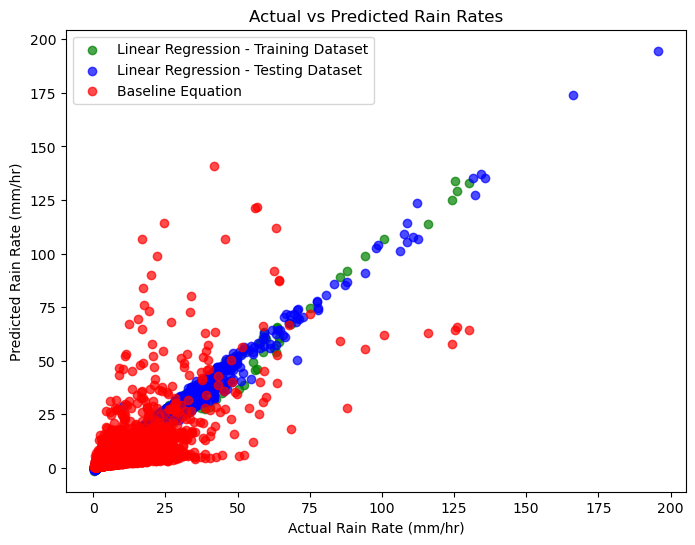

In [11]:
plt.figure(figsize=(8,6))

plt.scatter(y_test, y_pred_from_test, color='green', alpha=0.7, label='Linear Regression - Training Dataset')
plt.scatter(y_train, y_pred_from_train, color='blue', alpha=0.7, label='Linear Regression - Testing Dataset')
plt.scatter(y_test, y_pred_baseline, color='red', alpha=0.7, label='Baseline Equation')

plt.xlabel('Actual Rain Rate (mm/hr)')
plt.ylabel('Predicted Rain Rate (mm/hr)')
plt.title('Actual vs Predicted Rain Rates')
plt.legend()
plt.show()

3. Repeat 1 doing a grid search over polynomial orders, using a grid search over orders 0-9, and use cross-validation of 7 folds.  For the best polynomial model in terms of $R^2$, does it outperform the baseline and the linear regression model in terms of $R^2$ and root mean square error?

In [12]:
# Import libraries and this code block from M5N4 to define PolynomialRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(),
                         LinearRegression(**kwargs))

In [20]:
# Define parameter grid
param_grid = {'polynomialfeatures__degree': np.arange(0,10),
              'linearregression__fit_intercept': [True, False]}

grid = GridSearchCV(PolynomialRegression(), param_grid, cv=4, n_jobs=-1)

In [21]:
grid.fit(X_train, y_train)
print("Best parameters:", grid.best_params_)
print("Best cross-validated R²:", grid.best_score_)
best_polynomial = grid.best_estimator

Best parameters: {'linearregression__fit_intercept': True, 'polynomialfeatures__degree': np.int64(2)}
Best cross-validated R²: 0.9989897201462088


AttributeError: 'GridSearchCV' object has no attribute 'best_estimator'

In [22]:
best_polynomial = grid.best_estimator_

In [23]:
# Predict on both training and test data
y_pred_train_pn = best_polynomial.predict(X_train)
y_pred_test_pn = best_polynomial.predict(X_test)

train_r2 = r2_score(y_train, y_pred_train_pn)
train_mse = mean_squared_error(y_train, y_pred_train_pn)
train_rmse = np.sqrt(train_mse)

test_r2 = r2_score(y_test, y_pred_test_pn)
test_mse = mean_squared_error(y_test, y_pred_test_pn)
test_rmse = np.sqrt(test_mse)

print("Training Set R² Score:", train_r2)
print("Testing Set R² Score:", test_r2)
print("Training Set Root Mean Squared Error:", train_rmse)
print("Testing Set Root Mean Squared Error:", test_rmse)

Training Set R² Score: 0.999075527923727
Testing Set R² Score: 0.9988525985186296
Training Set Root Mean Squared Error: 0.2632070528352045
Testing Set Root Mean Squared Error: 0.28319589981753196


4. Repeat 1 with a Random Forest Regressor, and perform a grid_search on the following parameters:
   
   ```python
   {'bootstrap': [True, False],  
   'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],  
   'max_features': ['auto', 'sqrt'],  
   'min_samples_leaf': [1, 2, 4],  
   'min_samples_split': [2, 5, 10],  
   'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
   ```
  Can you beat the baseline, or the linear regression, or best polynomial model with the best optimized Random Forest Regressor in terms of $R^2$ and root mean square error?


Revision based on slack messages on 10/26. Set parameters to:

{"bootstrap": [True, False],
 "max_depth": [10, 100],
 "max_features": ["sqrt", 1.0],  
 "min_samples_leaf": [1, 4],
 "min_samples_split": [2, 10],
 "n_estimators": [200, 1000]}

In [24]:
# define the parameter grid that was provided
param_grid = {
    "bootstrap": [True, False],
    "max_depth": [10, 100],
    "max_features": ["sqrt", 1.0],
    "min_samples_leaf": [1, 4],
    "min_samples_split": [2, 10],
    "n_estimators": [200, 1000]
}

In [25]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(random_state=0)
grid_rf = GridSearchCV(
    estimator=forest,
    param_grid=param_grid,
    cv=7,n_jobs=-1,verbose=2)

In [26]:
grid_rf.fit(X_train, y_train)
print("Best Parameters:", grid_rf.best_params_)
print("Best Cross-Validation R²:", grid_rf.best_score_)
best_rf = grid_rf.best_estimator_

Fitting 7 folds for each of 64 candidates, totalling 448 fits
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   4.6s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   4.6s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   4.6s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   4.7s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   4.6s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   4.6s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total

/home/briette2/envs/xarray-climate/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=  36.1s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=  35.9s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=  35.9s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   5.6s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   5.6s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   5.6s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=  35.8s
[CV] END bootstrap=True, max_depth

In [27]:
# Predict on both training and test data
y_pred_train_rf = best_rf.predict(X_train)
y_pred_test_rf = best_rf.predict(X_test)

train_r2 = r2_score(y_train, y_pred_train_rf)
train_mse = mean_squared_error(y_train, y_pred_train_rf)
train_rmse = np.sqrt(train_mse)

test_r2 = r2_score(y_test, y_pred_test_rf)
test_mse = mean_squared_error(y_test, y_pred_test_rf)
test_rmse = np.sqrt(test_mse)

print("Training Set R² Score:", train_r2)
print("Testing Set R² Score:", test_r2)
print("Training Set Root Mean Squared Error:", train_rmse)
print("Testing Set Root Mean Squared Error:", test_rmse)

Training Set R² Score: 0.996747286883513
Testing Set R² Score: 0.9556625141383147
Training Set Root Mean Squared Error: 0.4937117962474791
Testing Set Root Mean Squared Error: 1.760413902314996
